In [10]:
using DrWatson
using DataFrames
using HDF5
using Statistics

In [215]:
datapath = "/Users/mr/2020-10-30_stationary_sweep"

"/Users/mr/2020-10-30_stationary_sweep"

In [217]:
records = map(readdir(datapath)) do fname
    prefix, params, suffix = parse_savename(fname)
    params = DataFrame(params)
    params["filename"] = fname
    params
end
df = vcat(records...)
sort!(df, [:N, :duration, :mean_s])

,N,duration,mean_s,filename
,Int64,Float64,Int64,String
1,1,20.0,20,N=1_duration=20_mean_s=20.hdf5
2,1,20.0,50,N=1_duration=20_mean_s=50.hdf5
3,1,20.0,100,N=1_duration=20_mean_s=100.hdf5
4,1,20.0,200,N=1_duration=20_mean_s=200.hdf5
5,1,26.799,20,N=1_duration=26.799_mean_s=20.hdf5
6,1,26.799,50,N=1_duration=26.799_mean_s=50.hdf5
7,1,26.799,100,N=1_duration=26.799_mean_s=100.hdf5
8,1,26.799,200,N=1_duration=26.799_mean_s=200.hdf5
9,1,35.909,20,N=1_duration=35.909_mean_s=20.hdf5


In [223]:
me_merged = DataFrame()
ce_merged = DataFrame()
for ((duration, mean_s), group) in pairs(groupby(df, [:duration, :mean_s]))
    local me = DataFrame()
    local ce = DataFrame()
    for fname in group.filename
        h5open(joinpath(datapath, fname)) do h5f
            dict = DataFrame()
            for obj in h5f["marginal_entropy"]
                dict[name(obj)] = read(obj)
            end
            me = vcat(me, dict; cols=:union)
            
            dict = DataFrame()
            for obj in h5f["conditional_entropy"]
                dict[name(obj)] = read(obj)
            end
            ce = vcat(ce, dict; cols=:union)
        end
    end
    me[:duration] = duration
    ce[:duration] = duration
    me[:mean_s] = mean_s
    ce[:mean_s] = mean_s
    me_merged = vcat(me_merged, me; cols=:union)
    ce_merged = vcat(ce_merged, ce; cols=:union)
end

In [224]:
show(me_merged, allcols=true)

4735000×6 DataFrame
│ Row     │ /marginal_entropy/GcTime │ /marginal_entropy/Sample │
│         │ Float64                  │ Float64                  │
├─────────┼──────────────────────────┼──────────────────────────┤
│ 1       │ 0.142184                 │ 42.0242                  │
│ 2       │ 0.0607807                │ 42.411                   │
│ 3       │ 0.039399                 │ 42.2557                  │
│ 4       │ 0.0390191                │ 42.0127                  │
│ 5       │ 0.0583263                │ 40.8254                  │
│ 6       │ 0.039006                 │ 39.531                   │
│ 7       │ 0.0400567                │ 44.3491                  │
│ 8       │ 0.0587357                │ 42.3347                  │
│ 9       │ 0.0388981                │ 41.8935                  │
│ 10      │ 0.0389539                │ 46.4155                  │
⋮
│ 4734990 │ 0.152771                 │ -12408.2                 │
│ 4734991 │ 0.148126                 │ -12922.7       

In [225]:
save(joinpath(datapath, "me.csv"), me_merged)
save(joinpath(datapath, "ce.csv"), ce_merged)

In [12]:
# me_merged = DataFrame(load(joinpath(datapath, "me.csv")))
# ce_merged = DataFrame(load(joinpath(datapath, "ce.csv")))

In [201]:
gaussian_data = DataFrame(load(projectdir("data", "gaussian_data", "gaussian_data.csv")))

,N,times,delta_t,mi
,Int64,Int64,Float64,Float64
1,328,20,0.0610352,0.191651
2,492,30,0.0610352,0.209987
3,655,40,0.0610352,0.228208
4,819,50,0.0610352,0.246538
5,983,60,0.0610352,0.264866
6,1147,70,0.0610352,0.283191
7,1311,80,0.0610352,0.301515
8,1475,90,0.0610352,0.319838
9,1638,100,0.0610352,0.338048


In [255]:
replace!(me_merged["/marginal_entropy/Sample"], NaN => 0.0)

4735000-element Array{Float64,1}:
     42.0241986153433
     42.41098931434919
     42.25566072493538
     42.01269752952397
     40.8254009526773
     39.53102609251949
     44.34908605653183
     42.33467653975859
     41.8934552835485
     46.41554711776269
     41.30838306681508
     41.14460943077012
     42.440389752048645
      ⋮
 -11916.878932023072
 -12408.197426654518
 -12922.726056120126
 -11800.80253447345
 -12624.63734703776
 -11494.50039380688
 -12803.224161588394
 -12203.118824816022
 -13016.949733246305
 -11449.329078895436
 -14849.471191164102
 -13188.422206129748

In [256]:
me = combine(groupby(me_merged, [:duration, :mean_s]), 
    "/marginal_entropy/Sample" => mean => :me, 
    "/marginal_entropy/Sample" => (x->var(x)/length(x)) => :var
)

,duration,mean_s,me,var
,Float64,Int64,Float64,Float64
1,20.0,20,42.0153,4.17576e-5
2,20.0,50,10.8953,0.00257534
3,20.0,100,-118.95,0.0159491
4,20.0,200,-517.797,0.0649289
5,26.799,20,55.1949,7.0532e-5
6,26.799,50,13.3945,0.00418713
7,26.799,100,-160.721,0.0256487
8,26.799,200,-695.434,0.105341
9,35.909,20,72.8646,0.00011762


In [257]:
ce = combine(groupby(ce_merged, [:duration, :mean_s]), 
    "/conditional_entropy/Sample" => mean => :ce, 
    "/conditional_entropy/Sample" => (x->var(x)/length(x)) => :var
)

,duration,mean_s,ce,var
,Float64,Int64,Float64,Float64
1,20.0,20,41.5218,5.00905e-6
2,20.0,50,10.3895,0.000261045
3,20.0,100,-119.501,0.00159376
4,20.0,200,-518.339,0.00651473
5,26.799,20,54.6321,7.48928e-6
6,26.799,50,12.7289,0.000420698
7,26.799,100,-161.545,0.002571
8,26.799,200,-695.863,0.0105462
9,35.909,20,72.1939,1.12617e-5


In [258]:
error = sqrt.(me.var + ce.var)

48-element Array{Float64,1}:
 0.006838612564254399
 0.053257697810223305
 0.13244949584978527
 0.26728937130864694
 0.008832964457066462
 0.06788101278944939
 0.16798706998131172
 0.3404225944822305
 0.011352602957762593
 0.08691126475797879
 0.21485863792529358
 0.43536153987816595
 0.014157409072905046
 ⋮
 0.05660681940317145
 0.4409404358189008
 1.0932403873041951
 2.214740258034841
 0.0730046718366994
 0.5374106787504724
 1.328607381266597
 2.6934096264653986
 0.1053058600180725
 0.6480873008661349
 1.6048037981390295
 5.468717141507521

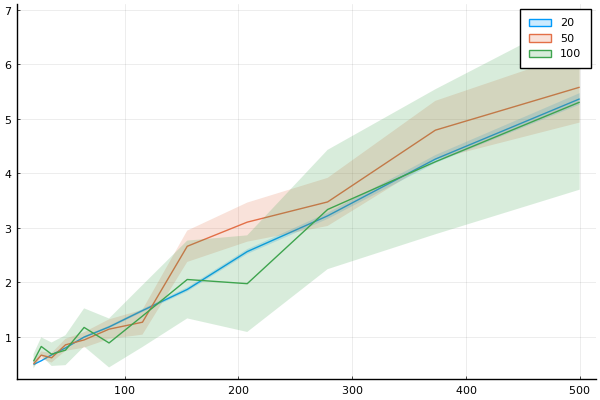

In [305]:
mi = DataFrame()
mi[:duration] = me.duration
mi[:mean_s] = me.mean_s
mi[:val] = me.me - ce.ce
mi[:error] = sqrt.(me.var + ce.var)
p = plot()
for (mean_s, group) in pairs(groupby(mi, :mean_s))
    if mean_s[1] == 200
        continue
    end
    plot!(p, group.duration, group.val, fillalpha=0.2, ribbon=group.error, label=mean_s[1])
end
p

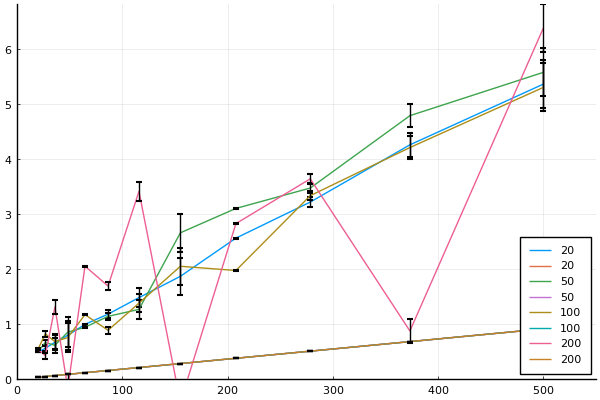

In [259]:
using Plots

p1 = plot(me.duration, [(me.me - ce.ce), 0.00183 .* me.duration], yerr=[error, zeros(size(error))]', group=me.mean_s, ylim=(0, :auto), xlim=(0, 550), legend=:bottomright)

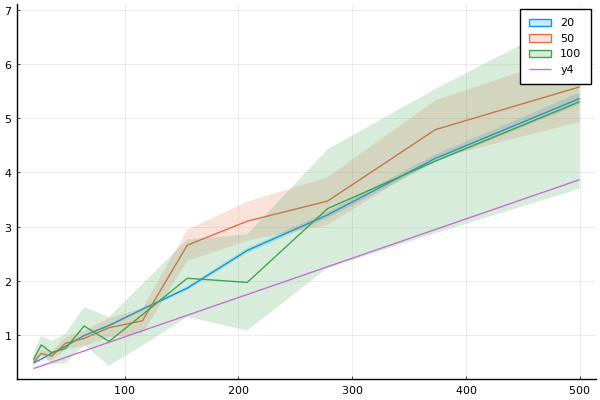

In [306]:
plot!(p, gaussian_data.times, gaussian_data.mi)

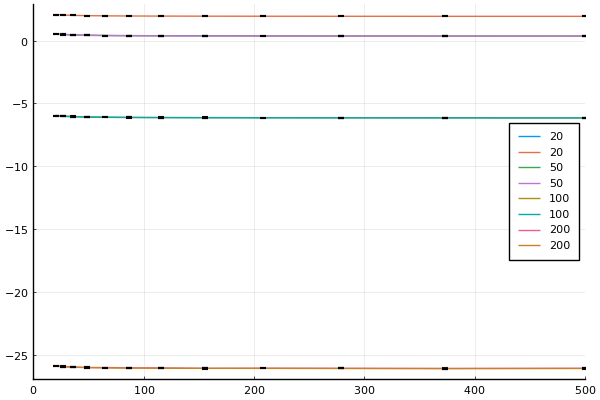

In [236]:
plot(me.duration, [me.me ./ me.duration, ce.ce ./ ce.duration], group=me.mean_s, yerr=[sqrt.(me.var) ./ me.duration, sqrt.(ce.var) ./ ce.duration]', xlim=(0, :auto))

In [302]:
import GaussianMcmc
using LinearAlgebra

function gaussian_mi(N, delta_t, mean_s)
    t = GaussianMcmc.time_matrix(N, delta_t)
    λ = 1/100
    κ = mean_s * λ
    μ = 1/20
    ρ = μ
    system = GaussianMcmc.System(κ, λ, ρ, μ)
    c_z = GaussianMcmc.corr_z(system, t)
    c_ss = c_z[1:N,1:N]
    c_xx = c_z[N+1:2N,N+1:2N]
    
    0.5 * (logdet(c_ss) + logdet(c_xx) - logdet(c_z))
end

times = range(20, 500, length=12)
Nmax = 4096
delta_t = times[end] / Nmax
mean_s = 100

N = map(x->round(Int, x), times ./ delta_t)

mi = gaussian_mi.(N, delta_t, mean_s)

gaussian_data = DataFrame(:N => N, :times => times, :delta_t => delta_t, :mean_s => mean_s, :mi => mi)

,N,times,delta_t,mean_s,mi
,Int64,Float64,Float64,Int64,Float64
1,164,20.0,0.12207,100,0.388633
2,521,63.6364,0.12207,100,0.707595
3,879,107.273,0.12207,100,1.02439
4,1236,150.909,0.12207,100,1.33994
5,1594,194.545,0.12207,100,1.65634
6,1951,238.182,0.12207,100,1.97184
7,2309,281.818,0.12207,100,2.28823
8,2666,325.455,0.12207,100,2.60373
9,3024,369.091,0.12207,100,2.92012


In [267]:
mi

6×3 Array{Float64,2}:
 0.389163  0.389163  0.389163
 0.725574  0.725574  0.725574
 1.0593    1.0593    1.0593
 1.39269   1.39269   1.39269
 1.72561   1.72561   1.72561
 2.05896   2.05896   2.05896

In [82]:
save(projectdir("data", "gaussian_data", "gaussian_data.csv"), gaussian_data)

In [52]:
me_groups = map(x->x["/marginal_entropy/Sample"], groupby(me_merged, :duration))

,duration,x1
,Int64,Float64
1,50,89.0175
2,50,83.0175
3,50,71.9641
4,50,89.7106
5,50,91.5359
6,50,85.5942
7,50,86.212
8,50,78.2535
9,50,74.8465


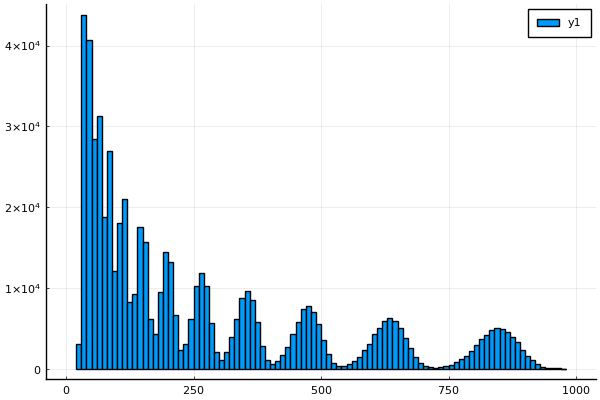

In [208]:
histogram(me_merged["/marginal_entropy/Sample"])

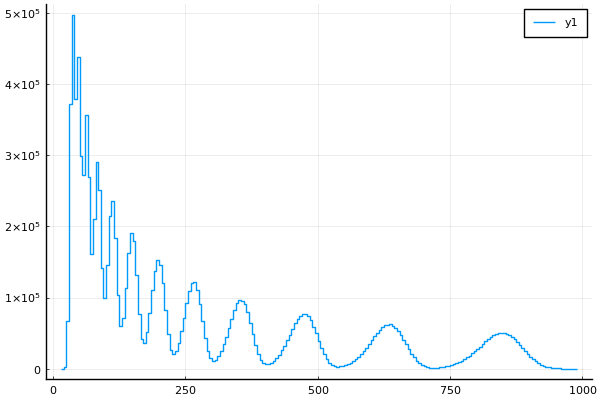

In [209]:
histogram(ce_merged["/conditional_entropy/Sample"])

In [69]:
function optimize_system(A, κ)
    f1 = sqrt(A/(2κ))
    λinv = 4f1*(2*(f1-1) + (f1^2 - 1)/f1)
    smean = κ*λinv
    ρ = (f1^2 - 1)/λinv
    rate = 1/(2λinv) * (f1 - 1)
    @show smean, rate
    nothing
end

Iᵣ(ρ,λ) = λ/2 * (sqrt(1+ρ/λ) - 1)
rtot(κ, ρ, λ) = 2κ*(1+ρ/λ)

rtot (generic function with 1 method)

In [53]:
optimize_system(10, 1)

(smean, rate) = (170.4396134799765, 0.00362611705184665)


In [62]:
Iᵣ.(rho, lambda)

20×20 Array{Float64,2}:
 0.00207107  0.00224745  0.00232051  …  0.00246621  0.00246794  0.00246951
 0.00366025  0.00414214  0.00436492     0.00486833  0.00487492  0.00488088
 0.005       0.00581139  0.0062132      0.00721111  0.00722524  0.00723805
 0.00618034  0.00732051  0.00791288     0.00949874  0.00952272  0.00954451
 0.00724745  0.00870829  0.0094949      0.0117349   0.0117708   0.0118034
 0.00822876  0.01        0.0109808   …  0.013923    0.0139725   0.0140175
 0.00914214  0.0112132   0.0123861      0.016066    0.0161306   0.0161895
 0.01        0.0123607   0.0137228      0.0181665   0.0182475   0.0183216
 0.0108114   0.0134521   0.015          0.020227    0.0203256   0.0204159
 0.0115831   0.0144949   0.016225       0.0222497   0.0223669   0.0224745
 0.0123205   0.0154951   0.0174037   …  0.0242366   0.0243734   0.024499
 0.0130278   0.0164575   0.018541       0.0261895   0.0263466   0.0264911
 0.0137083   0.0173861   0.019641       0.0281101   0.0282883   0.0284523
 0.0143649 

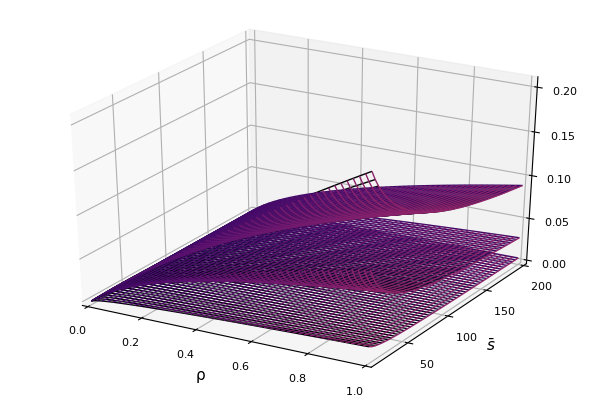

In [120]:
using LaTeXStrings
pyplot()
rho = range(0,1, length=50)
smean = range(10, 200, length=50)
kappa = 0.1
p = plot()
for kappa in [0.01, 0.7, 10]
    wireframe!(p, rho, smean, Iᵣ.(rho', (kappa ./ smean)), xlabel="ρ", ylabel=L"\bar{s}", label="$kappa")
end
p
# wireframe!(p, rho, lambda, rtot.(kappa, rho, lambda'))

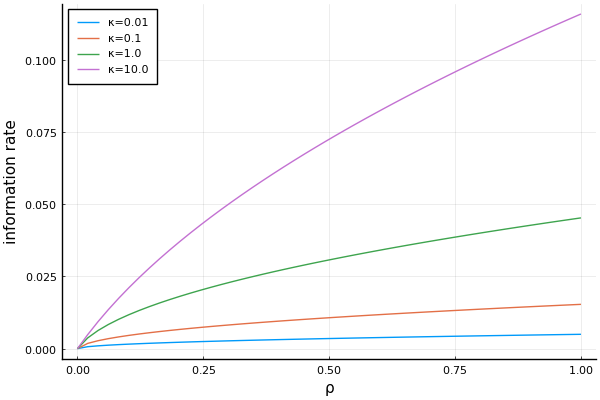

In [132]:
rho = range(0,1, length=50)
kappa = 10 .^ range(-2, 1, length=4)
smean = 100
plot(rho, Iᵣ.(rho, (kappa ./ smean)'), ylabel="information rate", xlabel="ρ", label=hcat(("κ=$k" for k in kappa)...))

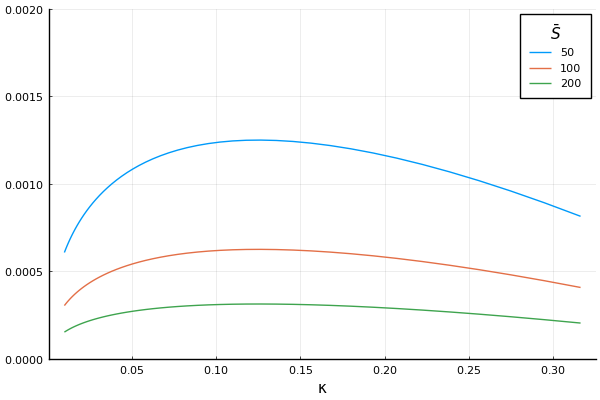

In [192]:
infrate(κ, smean, rtot) = κ/(2smean) * (sqrt(rtot/(2κ)) - 1)

rt = 1
smean = [50, 100, 200]'
κ = 10 .^ range(-2, -0.5, length=50)

plot(κ, infrate.(κ, smean, rt), ylim=(0,0.002), label=smean, legendtitle=L"\bar{S}", xlabel="κ")

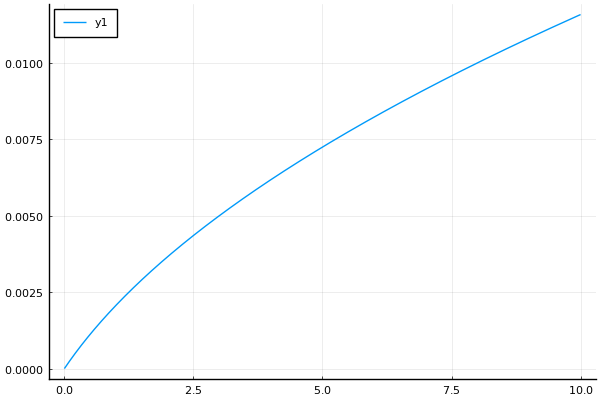

In [213]:
plot(0:0.01:10, x -> 1/(2*100) * (sqrt(1 + x) - 1))

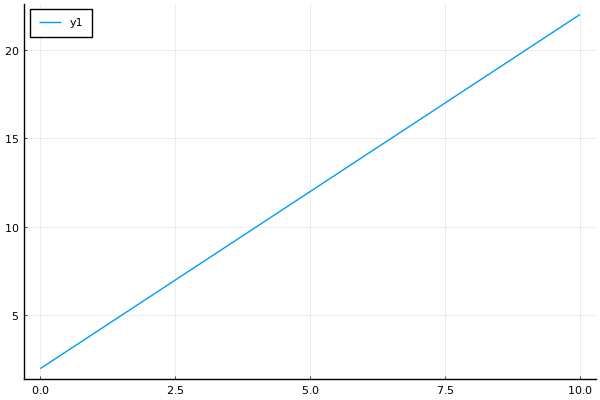

In [214]:
plot(0:0.01:10, x -> 2*100*(1/100 + x/100))